In [1]:
# Import necessary libraries and modules
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

from tqdm.auto import tqdm

import torch.nn.functional as F
import arff

import random

import pickle

In [2]:
# Open and load the training dataset from ARFF file
with open('_data_setup/ECG5000/ECG5000_TRAIN.arff') as f:
    train = arff.load(f)

# Open and load the testing dataset from ARFF file
with open('_data_setup/ECG5000/ECG5000_TEST.arff') as f:
    test = arff.load(f)  

In [3]:
# Display keys of the 'train' dictionary
print(train.keys())

dict_keys(['description', 'relation', 'attributes', 'data'])


In [4]:
# Display keys of the 'test' dictionary
print(test.keys())

dict_keys(['description', 'relation', 'attributes', 'data'])


In [5]:
# Display the value associated with the key 'description' in the 'train' dictionary
print(train['description'])

ECG5000 provenance not determined yet


In [6]:
# Display the value associated with the key 'description' in the 'test' dictionary
print(test['description'])

ECG5000 provenance not determined yet


In [7]:
# Display the values associated with the key 'relation' in the 'train' and 'test' dictionaries
print("Train relation:", train['relation'])
print("Test relation:", test['relation'])

Train relation: ECG5000
Test relation: ECG5000


In [8]:
# Display the lengths of attributes in the 'train' and 'test' dictionaries
train_attribute_length = len(train['attributes'])
test_attribute_length = len(test['attributes'])
print("Train attribute length:", train_attribute_length)
print("Test attribute length:", test_attribute_length)

Train attribute length: 141
Test attribute length: 141


In [9]:
# Create train_col and test_col lists using the given logic
train_col = []
test_col = []

for (x, y) in train['attributes']:
    train_col.append(str(x) + '_' + str(y))

for (x, y) in test['attributes']:
    test_col.append(str(x) + '_' + str(y))

In [10]:
# Create train_arr from train['data']
train_arr = np.array(train['data'])

# Create DataFrame df_train using train_arr and train_col
df_train = pd.DataFrame(data=train_arr, columns=train_col)

# Display the first few rows of df_train
df_train.head()

,att1_NUMERIC,att2_NUMERIC,att3_NUMERIC,att4_NUMERIC,att5_NUMERIC,att6_NUMERIC,att7_NUMERIC,att8_NUMERIC,att9_NUMERIC,att10_NUMERIC,...,att132_NUMERIC,att133_NUMERIC,att134_NUMERIC,att135_NUMERIC,att136_NUMERIC,att137_NUMERIC,att138_NUMERIC,att139_NUMERIC,att140_NUMERIC,"target_['1', '2', '3', '4', '5']"
0,-0.11252183,-2.8272038,-3.7738969,-4.3497511,-4.376041,-3.4749863,-2.1814082,-1.8182865,-1.2505219,-0.47749208,...,0.79216787,0.93354122,0.79695779,0.57862066,0.2577399,0.22807718,0.12343082,0.92528624,0.19313742,1
1,-1.1008778,-3.9968398,-4.2858426,-4.5065789,-4.0223767,-3.2343676,-1.5661258,-0.99225766,-0.75467971,0.042321173,...,0.53835583,0.65688079,0.78748958,0.72404623,0.55578372,0.47633335,0.77381971,1.1196209,-1.4362499,1
2,-0.56708802,-2.5934502,-3.8742297,-4.5840949,-4.1874487,-3.1514617,-1.7429402,-1.4906585,-1.1835803,-0.39422869,...,0.88607336,0.5314524,0.31137684,-0.021918959,-0.71368344,-0.53219671,0.32109663,0.90422673,-0.42179659,1
3,0.49047253,-1.9144071,-3.6163638,-4.3188235,-4.2680158,-3.8811104,-2.9932802,-1.6711314,-1.3338845,-0.96562916,...,0.35081636,0.49911056,0.60034499,0.8420694,0.95207354,0.99013318,1.0867984,1.403011,-0.38356426,1
4,0.80023202,-0.87425189,-2.3847613,-3.9732924,-4.3382241,-3.8024222,-2.5345096,-1.7834233,-1.5944504,-0.75319899,...,1.1488838,0.95843425,1.0590254,1.3716823,1.2773918,0.96030393,0.97101956,1.6143924,1.4214563,1


In [11]:
# Create train_arr from test['data']
test_arr = np.array(test['data'])

# Create DataFrame df_test using test_arr and test_col
df_test = pd.DataFrame(data=test_arr, columns=test_col)

# Display the first few rows of df_test
df_test.head()

,att1_NUMERIC,att2_NUMERIC,att3_NUMERIC,att4_NUMERIC,att5_NUMERIC,att6_NUMERIC,att7_NUMERIC,att8_NUMERIC,att9_NUMERIC,att10_NUMERIC,...,att132_NUMERIC,att133_NUMERIC,att134_NUMERIC,att135_NUMERIC,att136_NUMERIC,att137_NUMERIC,att138_NUMERIC,att139_NUMERIC,att140_NUMERIC,"target_['1', '2', '3', '4', '5']"
0,3.6908442,0.71141435,-2.1140915,-4.1410068,-4.5744716,-3.4319085,-1.9507914,-1.1070667,-0.63232248,0.33457718,...,0.022846766,0.18893657,0.48093188,0.62925026,0.57729083,0.66552725,1.0359968,1.4922866,-1.9050734,1
1,-1.3481323,-3.9960376,-4.2267496,-4.2511874,-3.4779528,-2.2284217,-1.8084877,-1.5342415,-0.77986138,-0.39799914,...,1.5709378,1.5913944,1.5491932,1.193077,0.5151344,0.12627351,0.26753217,1.0711484,-1.164009,1
2,1.0242946,-0.59031419,-1.9169491,-2.806989,-3.5279051,-3.638675,-2.7797674,-2.0190308,-1.9807535,-1.4406797,...,0.44350192,0.82758242,1.237007,1.2351214,1.7381027,1.8007674,1.8163009,1.4739633,1.3897666,1
3,0.54565692,-1.014383,-2.3166977,-3.6340397,-4.196857,-3.7580926,-3.1944444,-2.2217637,-1.5885544,-1.2021459,...,0.77752982,1.1192396,0.90298365,0.5540976,0.49705263,0.41811561,0.70310771,1.0646019,-0.044853163,1
4,0.66113283,-1.5524706,-3.1246406,-4.3133515,-4.0170422,-3.0059934,-1.832411,-1.5038856,-1.0717055,-0.5213163,...,1.2808227,1.4943155,1.6187644,1.4474491,1.2385768,1.7496922,1.9868029,1.4227564,-0.35778384,1


In [12]:
# Concatenate df_train and df_test to create a new DataFrame df
df = pd.concat([df_train, df_test]).copy()

In [14]:
# Saving the dataset
#df.to_csv('_data_setup/data.csv',index=False)

In [15]:
# Display the value counts of the specified column in the DataFrame df
print(df['target_[\'1\', \'2\', \'3\', \'4\', \'5\']'].value_counts())

1    2919
2    1767
4     194
3      96
5      24
Name: target_['1', '2', '3', '4', '5'], dtype: int64


In [16]:
df.columns

Index(['att1_NUMERIC', 'att2_NUMERIC', 'att3_NUMERIC', 'att4_NUMERIC',
       'att5_NUMERIC', 'att6_NUMERIC', 'att7_NUMERIC', 'att8_NUMERIC',
       'att9_NUMERIC', 'att10_NUMERIC',
       ...
       'att132_NUMERIC', 'att133_NUMERIC', 'att134_NUMERIC', 'att135_NUMERIC',
       'att136_NUMERIC', 'att137_NUMERIC', 'att138_NUMERIC', 'att139_NUMERIC',
       'att140_NUMERIC', 'target_['1', '2', '3', '4', '5']'],
      dtype='object', length=141)

In [17]:
# Rename a column in the DataFrame df
df.rename({"target_['1', '2', '3', '4', '5']": 'target'}, axis=1, inplace=True)

In [18]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [19]:
# Define the class_names list
class_names = ['normal', 'R on T', 'PVC', 'SP', 'UB']

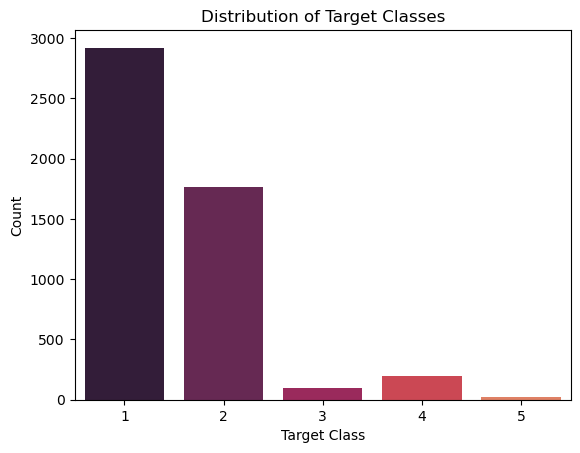

In [21]:
# Create a count plot to visualize the distribution of target classes
sns.set_palette('rocket')  # Set the color palette
sns.countplot(data=df, x='target', palette=sns.color_palette())  # Create the count plot

# Add title and labels to the plot
plt.title('Distribution of Target Classes')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Save the plot
#plt.savefig('_plots/Distribution of Target Classes.jpeg')

# Show the plot
plt.show()

In [22]:
# For each column in the DataFrame df
for col in df.columns:
    # Convert each element in the column to a float value
    df[col] = df[col].apply(lambda x: float(x))

In [23]:
# Display information about the DataFrame df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4499
Columns: 141 entries, att1_NUMERIC to target
dtypes: float64(141)
memory usage: 5.4 MB
None


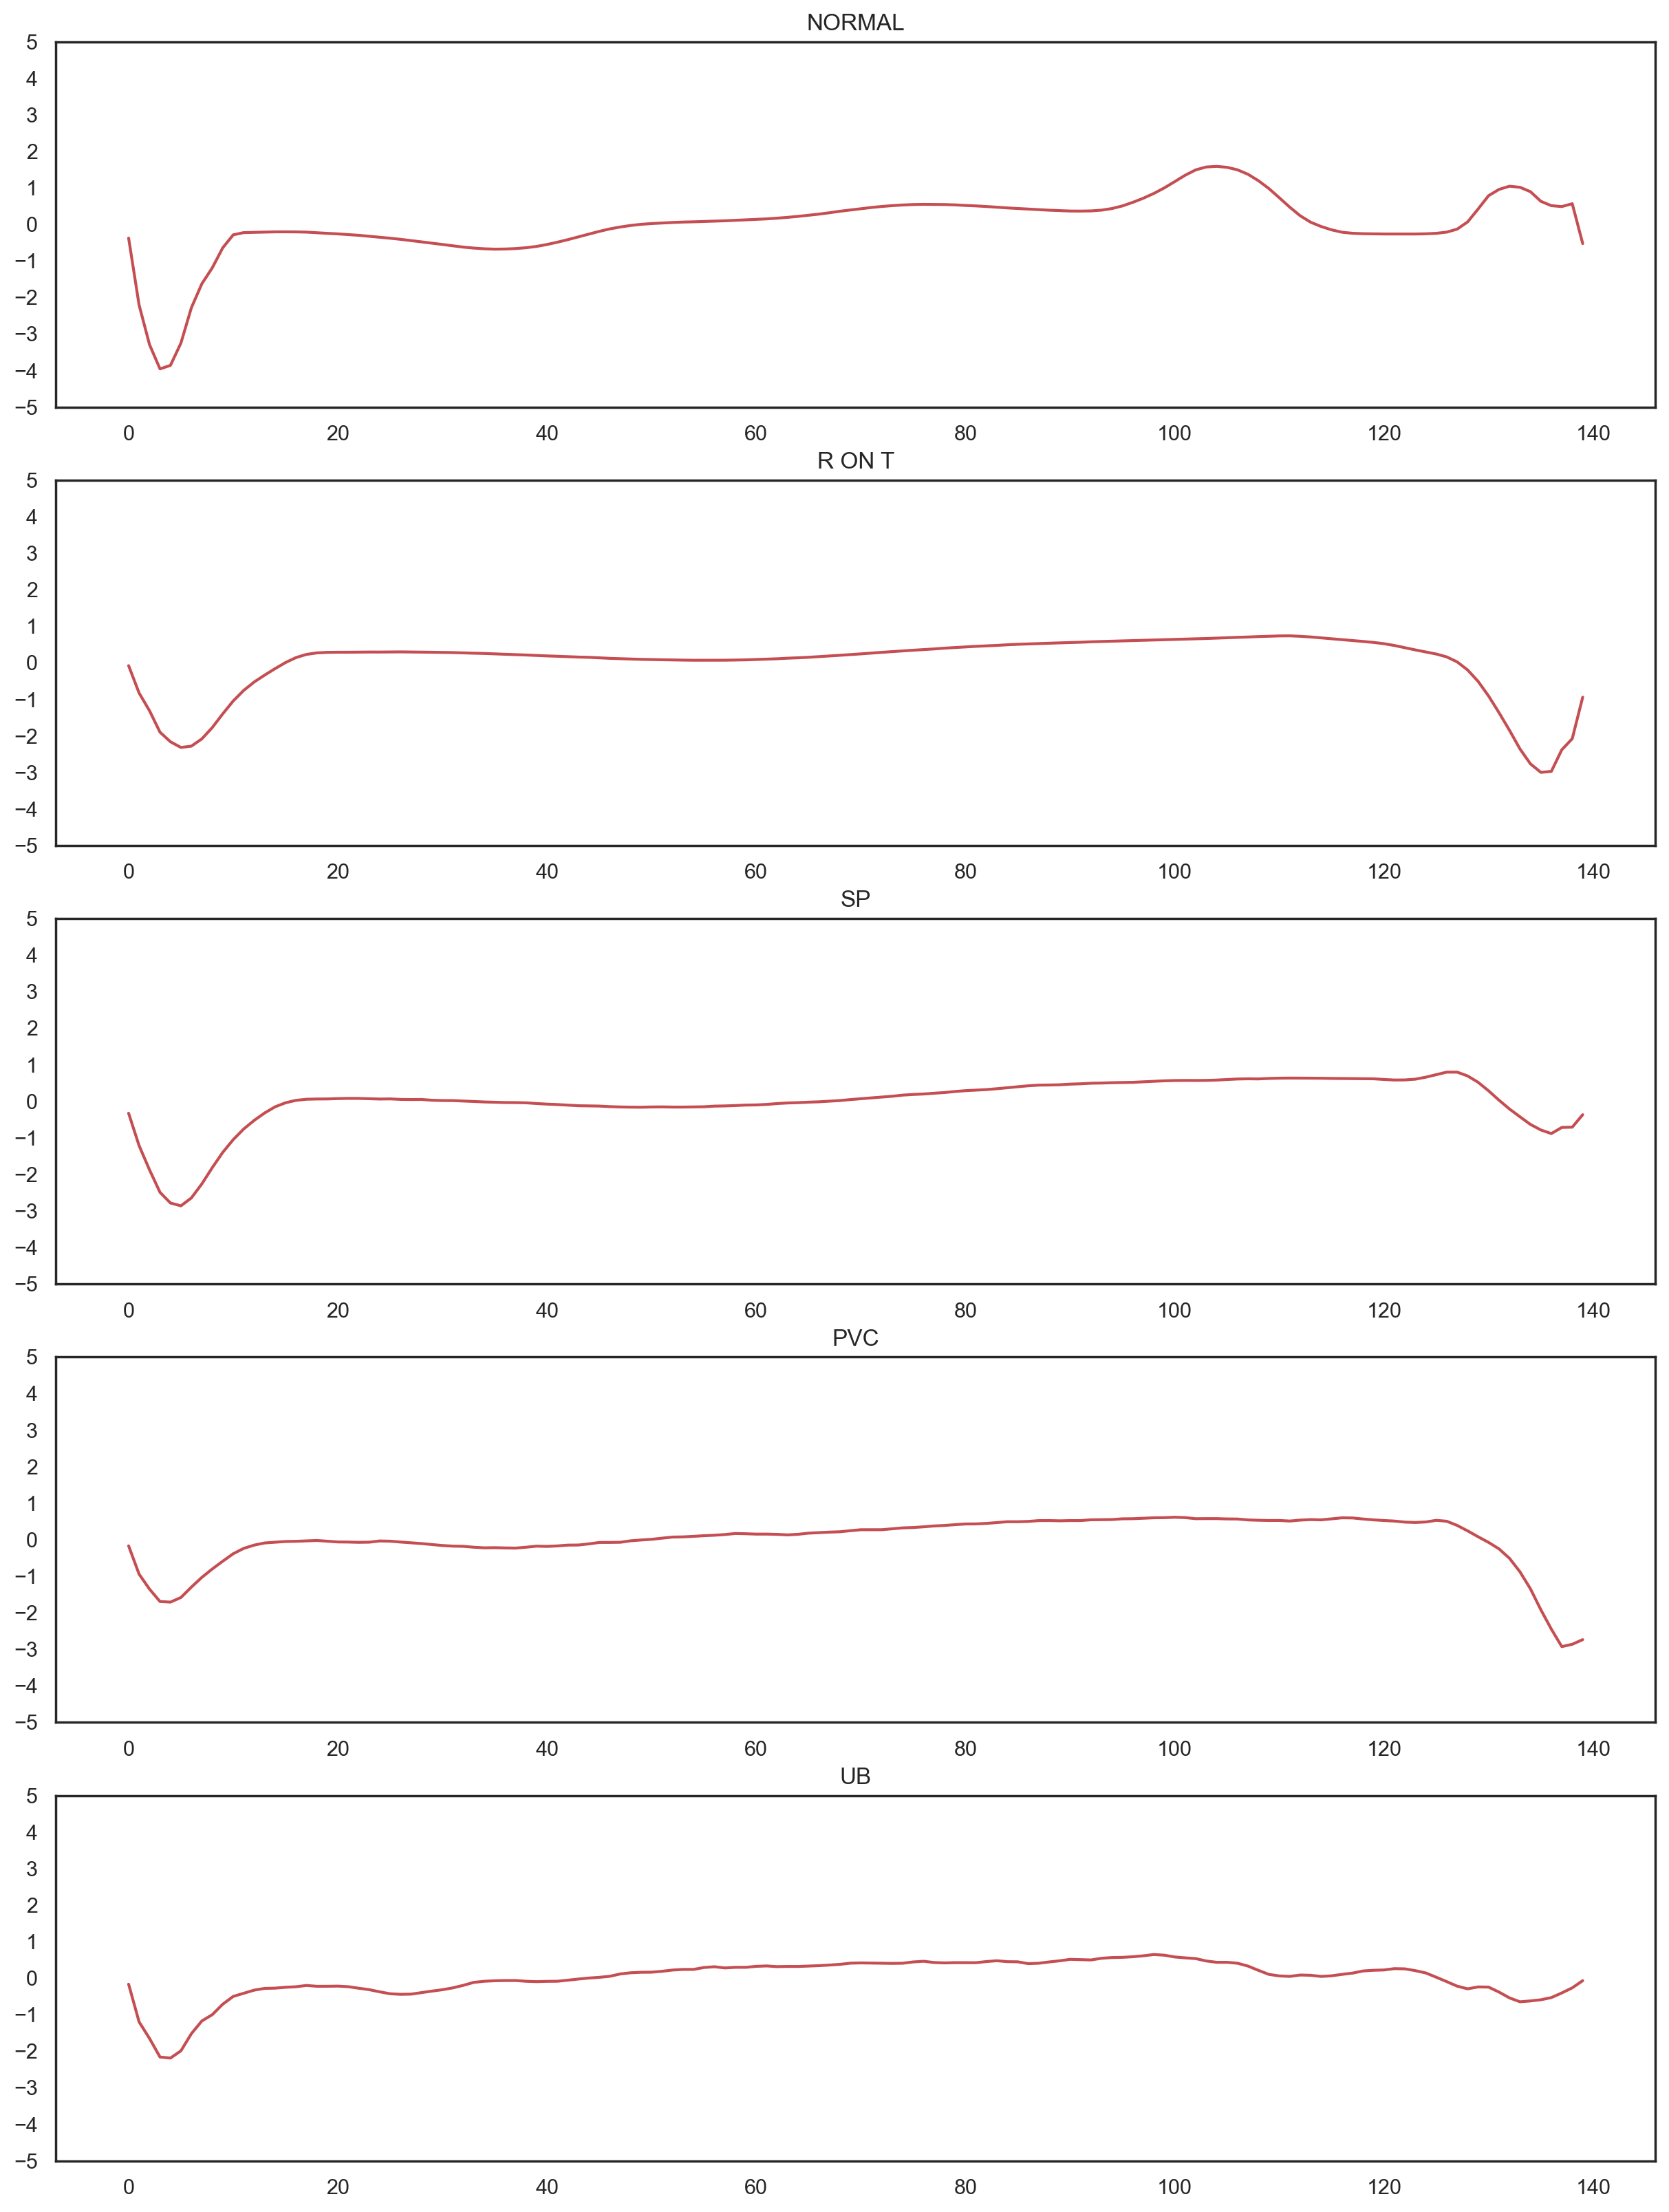

In [24]:
# Set the Seaborn theme and style
sns.set_theme(style='white')

# Create a figure for the subplots
plt.figure(figsize=(15, 20), dpi=200)

# Iterate through each target class and create a line plot
for num, target_ in enumerate(df['target'].value_counts().keys(), start=1):
    plt.subplot(len(df['target'].value_counts().keys()), 1, num)  # Create a subplot
    
    # Prepare data for the line plot
    x_values = range(0, len(df[df['target'] == target_].groupby(['target']).mean().iloc[0].values))
    y_values = df[df['target'] == target_].groupby(['target']).mean().iloc[0].values
    
    # Create a line plot using Seaborn
    sns.lineplot(x=x_values, y=y_values,color='r')
    
    plt.yticks([x - 5 for x in range(11)])  # Set custom y-ticks
    
    plt.title(class_names[int(target_) - 1].upper())  # Add subplot title
    
# Save the plot
#plt.savefig('_plots/ECG_classes.jpeg')

# Show the plots
plt.show()

In [25]:
# Define a function to plot time series with uncertainty
def plot_time_series_class(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)
    
    # Calculate smooth path and path deviation
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    # Calculate lines for shading
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    # Plot smooth path and shaded region
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )

    # Set the title of the plot
    ax.set_title(class_name)

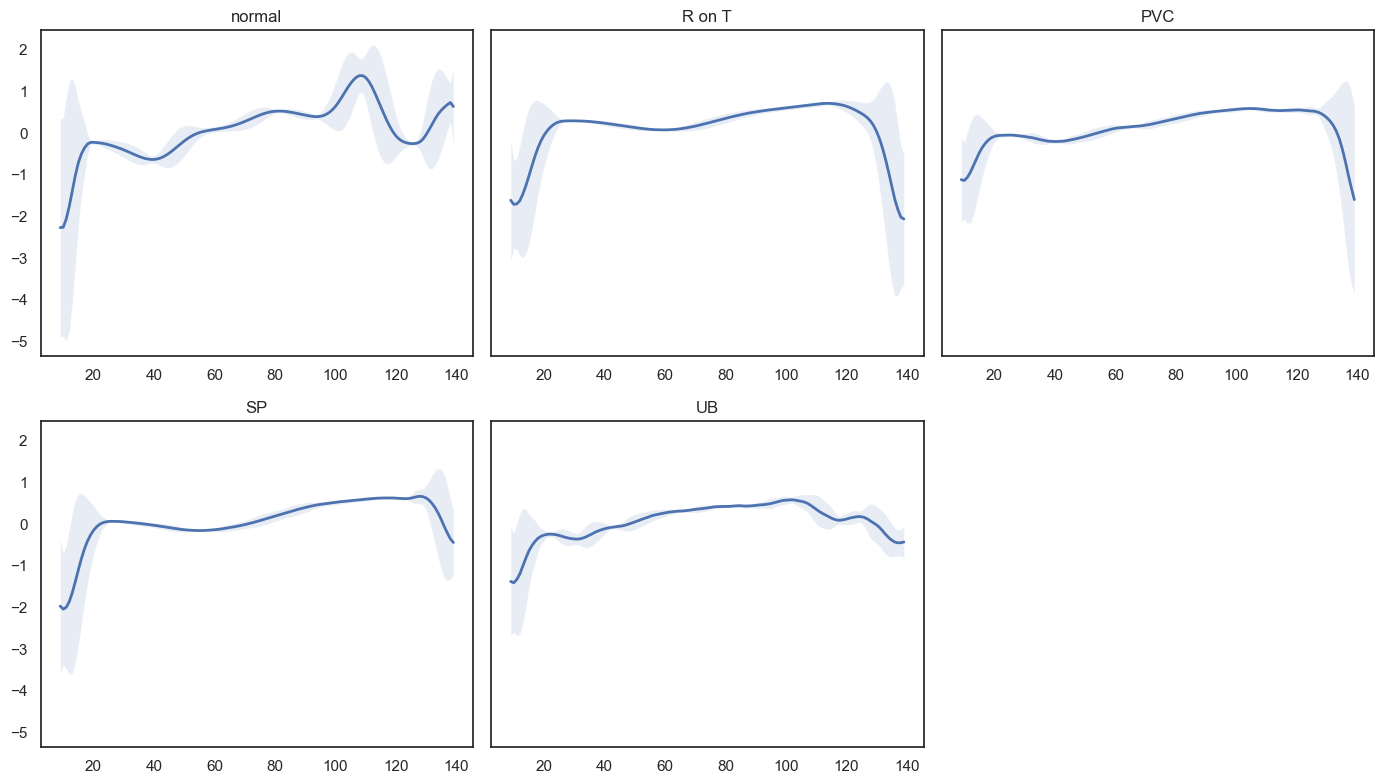

In [26]:
# Get unique classes from the target column
classes = np.unique(df.target)

# Create a figure and subplots grid
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8))

# Loop through each class and plot time series
for i, cls in enumerate(classes):
    ax = axs.flat[i]  # Get the current subplot axis
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)  # Plot time series for the class

# Remove the last subplot to adjust layout
fig.delaxes(axs.flat[-1])
fig.tight_layout()

# Save the plot
#plt.savefig('_plots/Smoothing_ECG.jpeg')

In [27]:
# Filter the DataFrame for a specific target class
normal_df = df[df.target == 1].drop(labels='target', axis=1)

# Get the shape of the filtered DataFrame
print(normal_df.shape)

(2919, 140)


In [28]:
# Filter the DataFrame for non-'normal' target classes
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)

# Get the shape of the filtered DataFrame and print info
anomaly_df_shape = anomaly_df.shape
print("Shape of anomaly_df:", anomaly_df_shape)

Shape of anomaly_df: (2081, 140)


In [29]:
RANDOM_SEED = 42

In [30]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)

# Split the validation set into validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=RANDOM_SEED)   

In [31]:
# Define a function to create a dataset
def create_dataset(df):
    # Convert DataFrame to sequences of lists
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Create a dataset of torch tensors
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Get the shape of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features

In [32]:
# Create train dataset, sequence length, and number of features
train_dataset, seq_len_train, n_features_train = create_dataset(train_df)

# Create validation dataset
val_dataset, _, _ = create_dataset(val_df)

# Create test datasets for normal and anomaly classes
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [33]:
# Use the seq_len variable
print("Sequence Length:", seq_len_train)

Sequence Length: 140


In [34]:
# Use the n_features variable
print("Number of Features:", n_features_train)

Number of Features: 1


In [35]:
# Define the Encoder class
class Encoder(nn.Module):
    # Constructor
    def __init__(self, seq_len, n_features, embedding_dim=64):
        # Call the parent class constructor
        super(Encoder, self).__init__()

        # Initialize instance variables
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        # Define LSTM layers
        self.rnn1 = nn.LSTM(input_size=n_features,
                            hidden_size=self.hidden_dim,
                            num_layers=1,
                            batch_first=True)
        
        self.rnn2 = nn.LSTM(input_size=self.hidden_dim,
                            hidden_size=embedding_dim,
                            num_layers=1,
                            batch_first=True)

    # Forward pass
    def forward(self, x):
        # Reshape input
        x = x.reshape((1, self.seq_len, self.n_features))
        
        # Pass through LSTM layers
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        
        # Reshape hidden state
        return hidden_n.reshape((self.n_features, self.embedding_dim))


In [36]:
import torch.nn as nn

# Define the Decoder class
class Decoder(nn.Module):
    # Constructor
    def __init__(self, seq_len, input_dim=64, n_features=1):
        # Call the parent class constructor
        super(Decoder, self).__init__()
        
        # Initialize instance variables
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        
        # Define LSTM layers
        self.rnn1 = nn.LSTM(input_size=input_dim,
                            hidden_size=input_dim,
                            num_layers=1,
                            batch_first=True)

        self.rnn2 = nn.LSTM(input_size=input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=1,
                            batch_first=True)
        
        # Define the output linear layer
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    
    # Forward pass
    def forward(self, x):
        # Repeat and reshape input
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        
        # Pass through LSTM layers
        x, (_, _) = self.rnn1(x)
        x, (_, _) = self.rnn2(x)
        
        # Reshape and apply output layer
        x = x.reshape((self.seq_len, self.hidden_dim))
        x = self.output_layer(x)
        return x

In [37]:
import torch.nn as nn

# Define the RecurrentAutoencoder class
class RecurrentAutoencoder(nn.Module):
    # Constructor
    def __init__(self, seq_len, n_features, embedding_dim=64):
        # Call the parent class constructor
        super(RecurrentAutoencoder, self).__init__()
        
        # Create an instance of the Encoder class
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        
        # Create an instance of the Decoder class
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
    
    # Forward pass
    def forward(self, x):
        # Encode and then decode the input
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [38]:
# Create an instance of the RecurrentAutoencoder model
model = RecurrentAutoencoder(seq_len_train, n_features_train, 128)

In [39]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [40]:
#model.state_dict()

In [41]:
import copy
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

# Define the train_model function
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum')
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    patience = 5
    counter = 0
  
    for epoch in tqdm(range(1, n_epochs+1)):
        model = model.train()
        train_losses = []
        for seq_true in (train_dataset):
            optimizer.zero_grad()
            seq_true = seq_true
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.inference_mode():
            for seq_true in val_dataset:
                seq_true = seq_true
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            
        if counter == patience:
            break
            
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [154]:
model, history = train_model(model,train_dataset,val_dataset,n_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: train loss 21.701945150345384 val loss 20.69276537585991
Epoch 20: train loss 18.12514288316855 val loss 17.47974170841048
Epoch 30: train loss 15.287304001054375 val loss 14.605040631603462


In [42]:
# Save the trained model to a binary file
#with open('_models/model_1.pkl', 'wb') as file:
#    pickle.dump(model, file)

In [43]:
# Load a saved model from a binary file
with open('_models/model_1.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [44]:
loaded_model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [45]:
# Define the loss function
lossfn = nn.L1Loss()

In [46]:
# Set the loaded model to evaluation mode
loaded_model.eval()

# Initialize a list to store normal loss values
normal_loss_lst = []

# Loop through instances in the test_normal_dataset
with torch.inference_mode():
    for instance in test_normal_dataset:
        # Generate predictions using the loaded model
        pred = loaded_model(instance)
        
        # Calculate the loss between predictions and instance
        loss = lossfn(pred, instance)
        
        # Append the loss value to the normal loss list
        normal_loss_lst.append(loss.item())

In [47]:
# Set the loaded model to evaluation mode
loaded_model.eval()

# Initialize a list to store anomaly loss values
anomaly_loss_lst = []

# Loop through instances in the test_anomaly_dataset
with torch.inference_mode():
    for instance in test_anomaly_dataset:
        # Generate predictions using the loaded model
        pred = loaded_model(instance)
        
        # Calculate the loss between predictions and instance
        loss = lossfn(pred, instance)
        
        # Append the loss value to the anomaly loss list
        anomaly_loss_lst.append(loss.item())

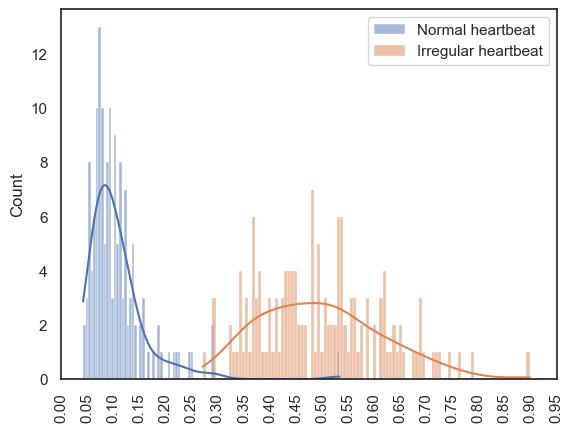

In [48]:
# Create histograms for normal and anomaly loss values
sns.histplot(x=normal_loss_lst, bins=100, label='Normal heartbeat',kde = True)
sns.histplot(x=random.choices(anomaly_loss_lst, k=len(normal_loss_lst)), bins=100, label='Irregular heartbeat',kde = True)

# Set custom x-axis tick values
plt.xticks([x * 0.05 for x in range(0, 20)])

# Add legend
plt.legend()

#Rotate x-ticks
plt.xticks(rotation = 90)

# Save the plot
#plt.savefig('_plots/Loss Distribution.jpeg')

# Show the plot
plt.show()

In [49]:
# Define the threshold value
threshold = 0.26

In [50]:
# Randomly select instances from test_normal_dataset and test_anomaly_dataset
num_instances = 5
random_normal_test = random.choices(test_normal_dataset, k=num_instances)
random_anomaly_test = random.choices(test_anomaly_dataset, k=num_instances)

In [51]:
# Set the loaded model to evaluation mode
loaded_model.eval()

# Initialize lists to store normal predictions and losses
normal_pred_lst = []
normal_pred_loss_lst = []

# Loop through instances in random_normal_test
with torch.inference_mode():
    for instance in random_normal_test:
        # Generate predictions using the loaded model
        pred = loaded_model(instance)
        
        # Append the prediction to the normal predictions list
        normal_pred_lst.append(pred)
        
        # Calculate the loss between predictions and instance
        loss = lossfn(pred, instance)
        
        # Append the loss value to the normal pred loss list
        normal_pred_loss_lst.append(loss.item())

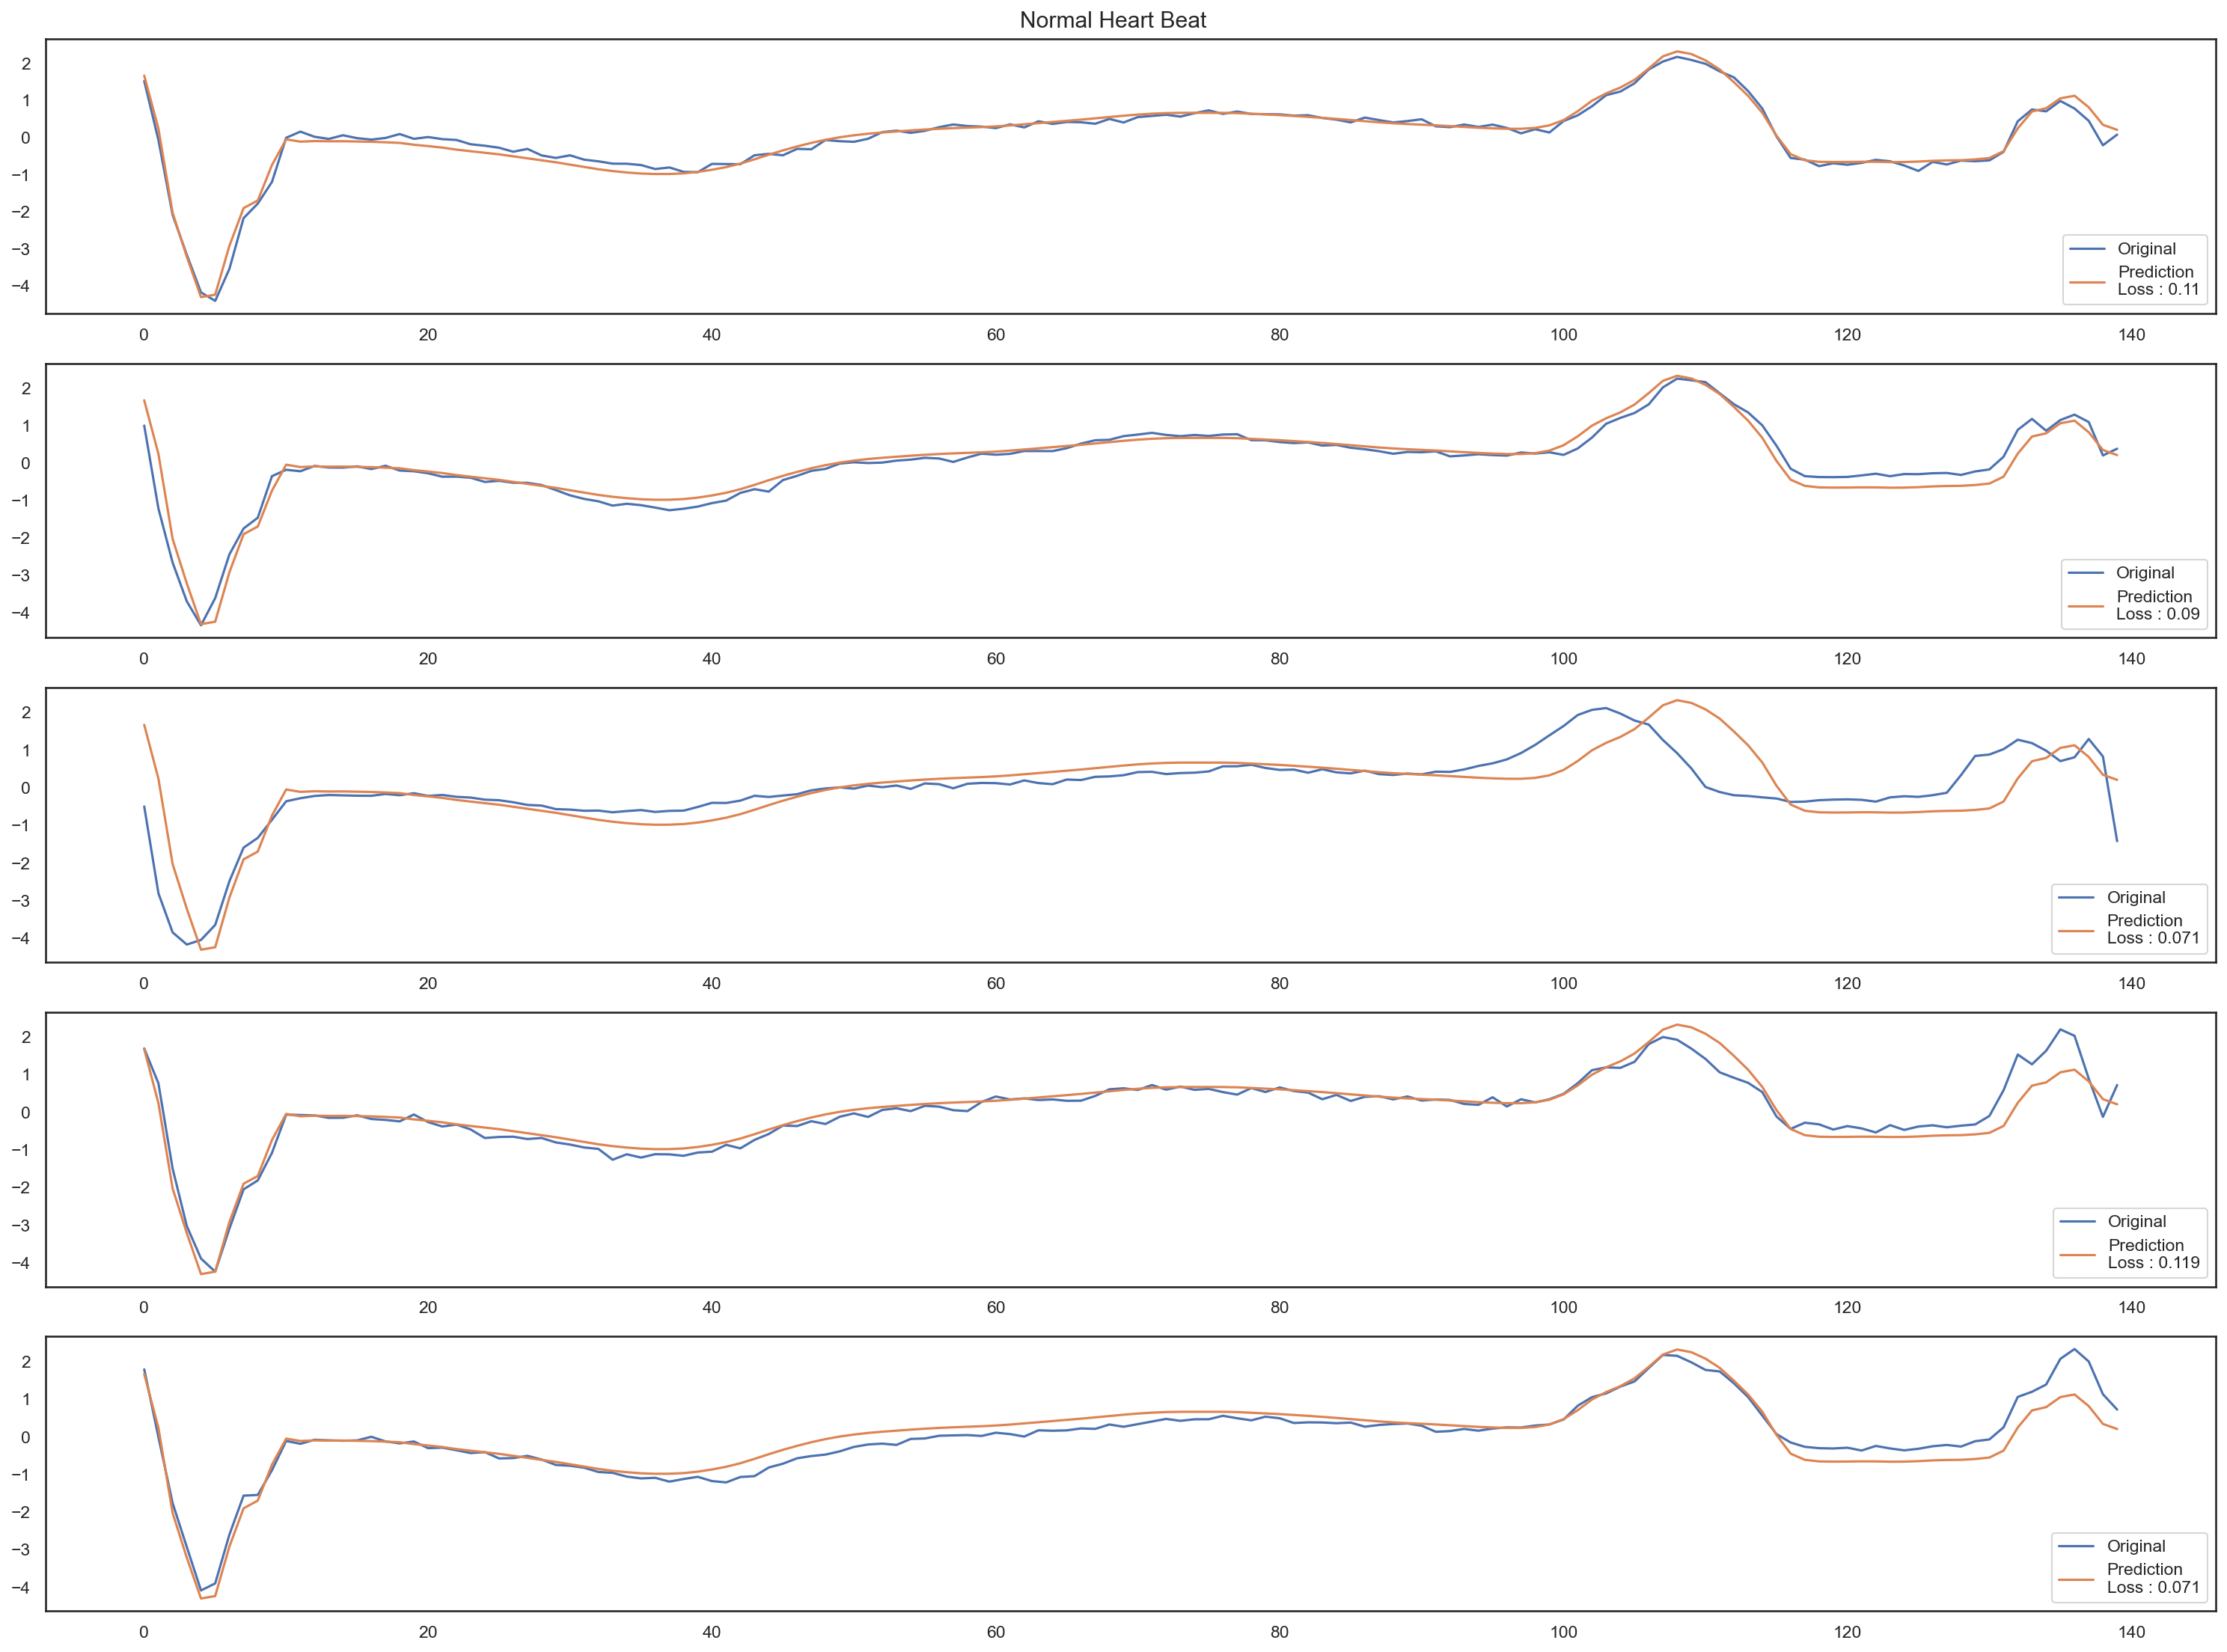

In [52]:
plt.figure(figsize=(20,15),dpi = 150)

for num,instance in enumerate(random_normal_test,start = 1):
    
    plt.subplot(5,1,num)
    
    sns.lineplot(x = range(len(np.array(instance.squeeze()))),y = np.array(instance.squeeze()),label = 'Original')
    
    sns.lineplot(x = range(len(np.array(normal_pred_lst[num-1].squeeze()))),y = np.array(normal_pred_lst[0].squeeze()),label = f'Prediction\nLoss : {round(normal_pred_loss_lst[num-1],3)}')
    
    plt.legend(loc = 4)
    
plt.suptitle('Normal Heart Beat')

plt.tight_layout()

# Save the plot
#plt.savefig('_plots/Normal Heart Beat.jpeg')

In [53]:
# Set the loaded model to evaluation mode
loaded_model.eval()

# Initialize lists to store anomaly predictions and losses
anomaly_pred_lst = []
anomaly_pred_loss_lst = []

# Loop through instances in random_anomaly_test
with torch.inference_mode():
    for instance in random_anomaly_test:
        # Generate predictions using the loaded model
        pred = loaded_model(instance)
        
        # Append the prediction to the anomaly predictions list
        anomaly_pred_lst.append(pred)
        
        # Calculate the loss between predictions and instance
        loss = lossfn(pred, instance)
        
        # Append the loss value to the anomaly pred loss list
        anomaly_pred_loss_lst.append(loss.item())

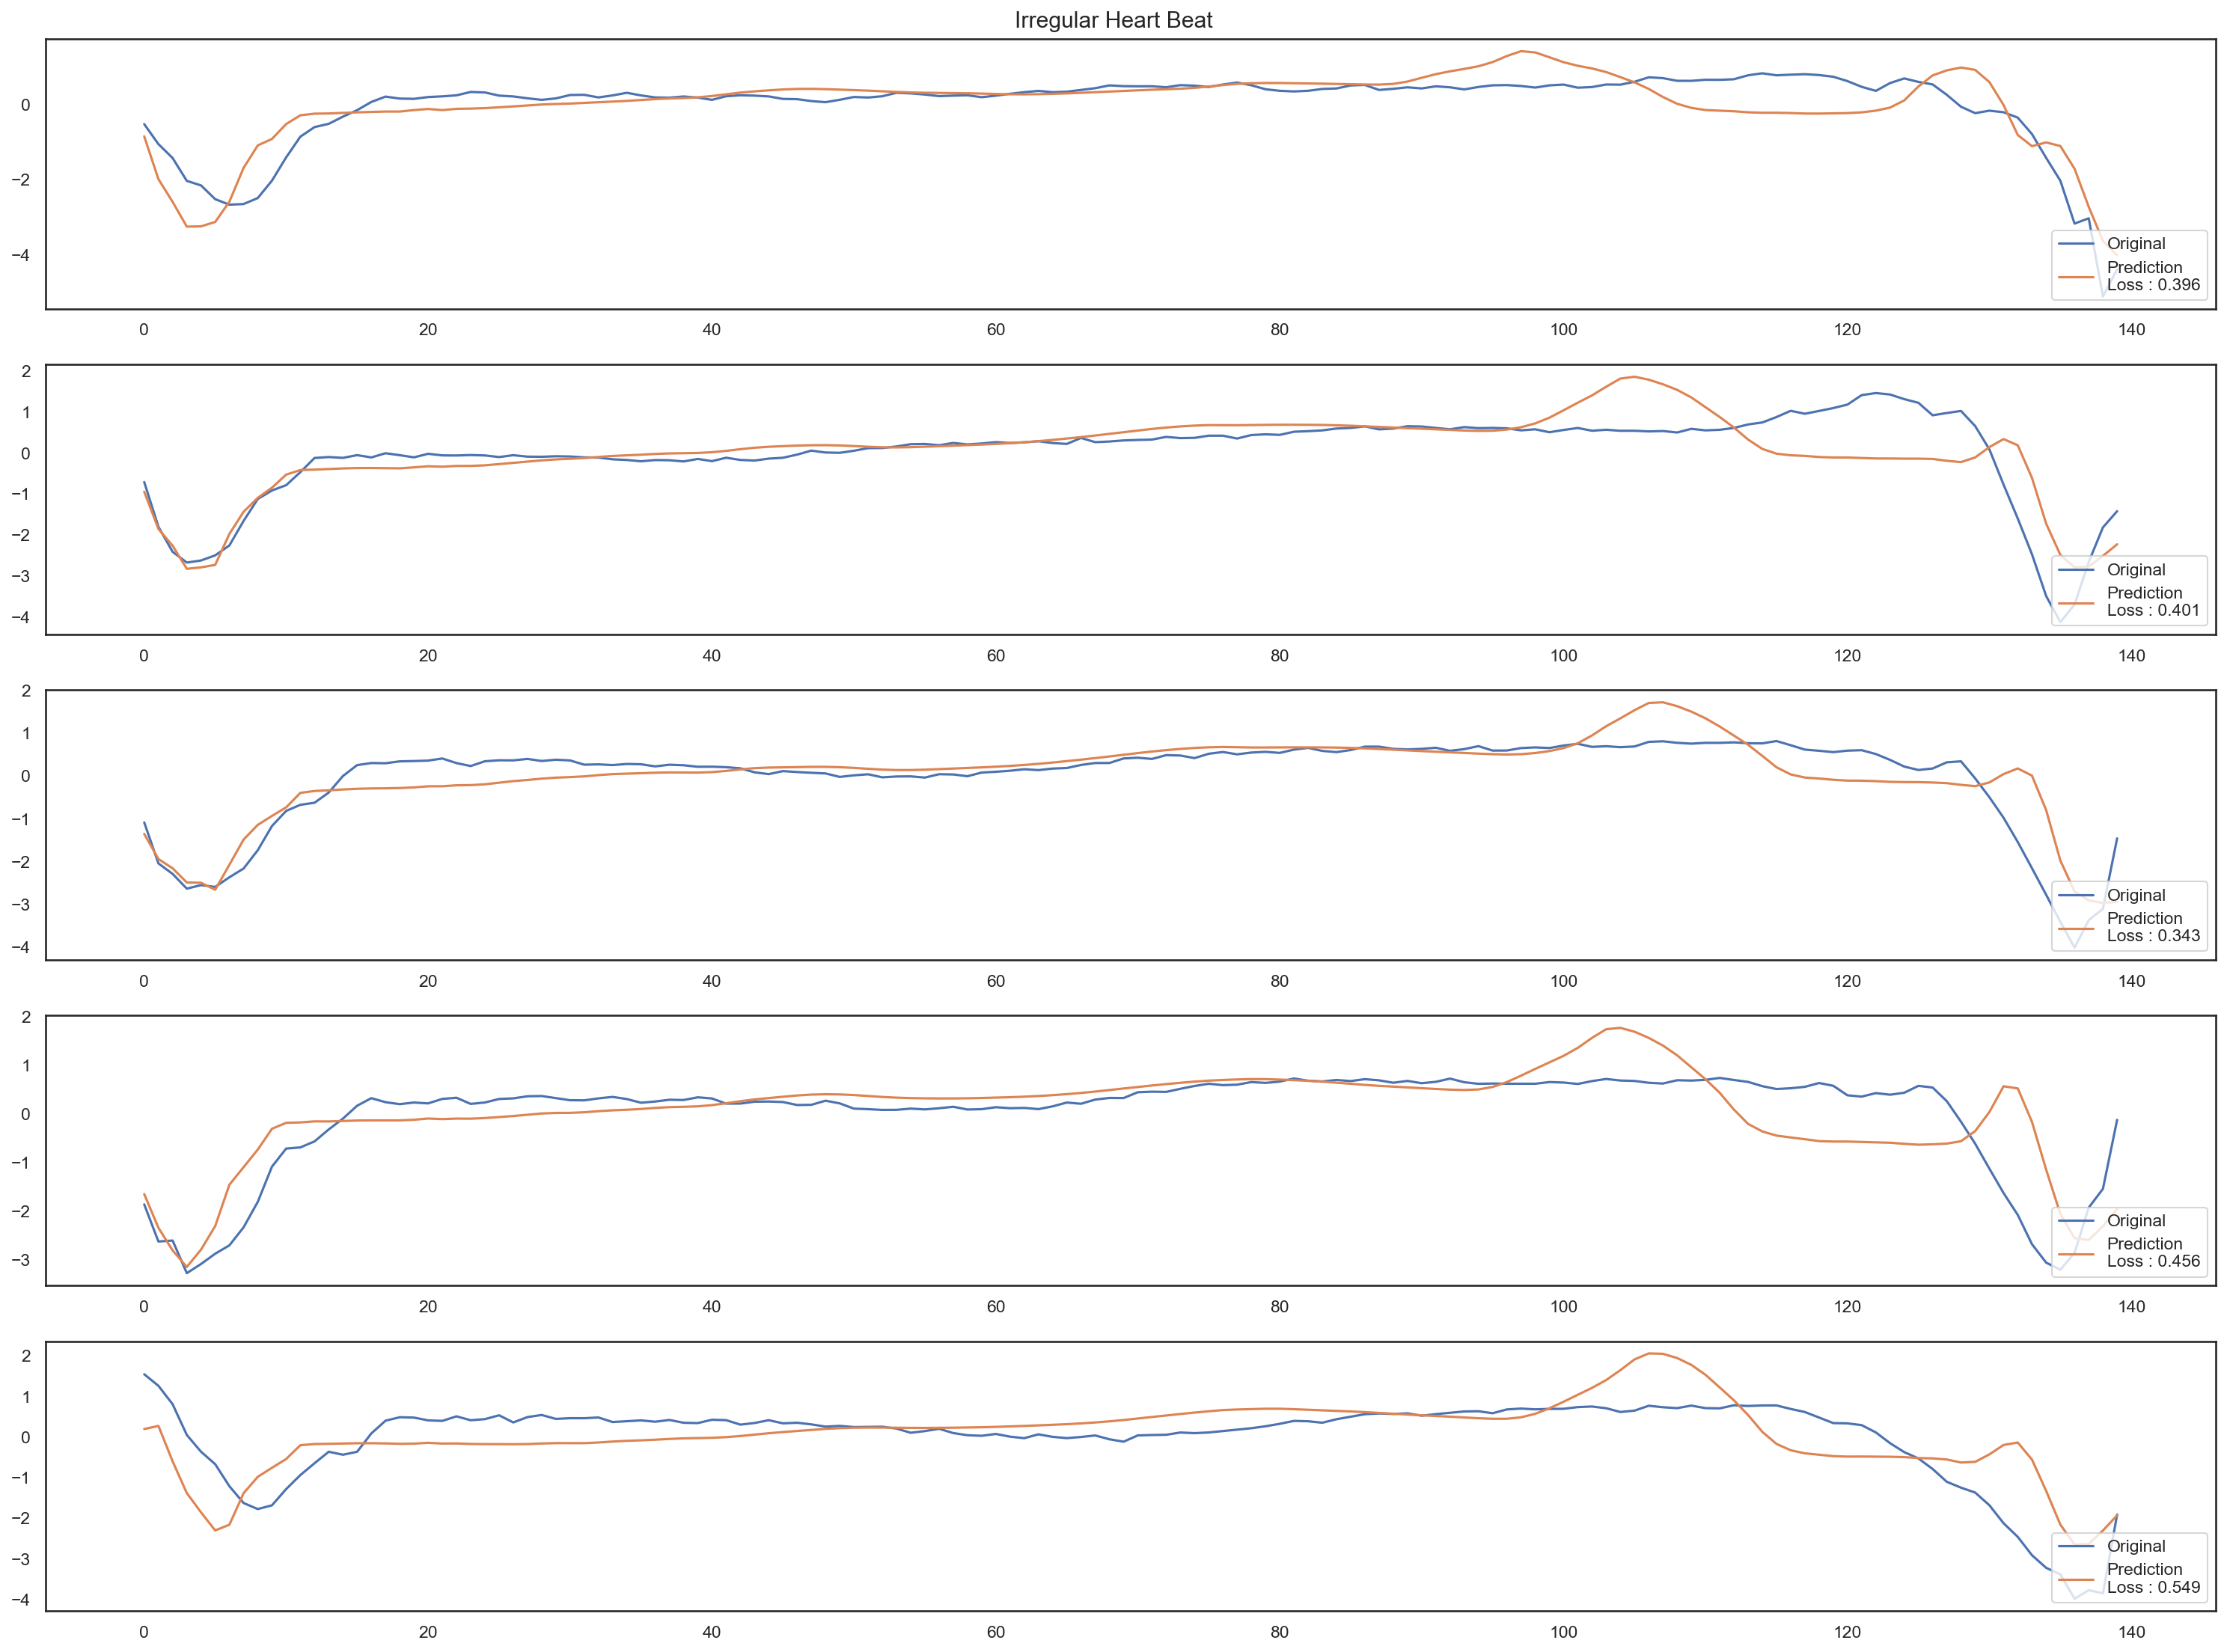

In [54]:
# Create a figure for the subplots
plt.figure(figsize=(20, 15), dpi=150)

# Loop through instances in random_anomaly_test
for num, instance in enumerate(random_anomaly_test, start=1):
    # Create a subplot
    plt.subplot(5, 1, num)
    
    # Plot the original time series
    sns.lineplot(x=range(len(np.array(instance.squeeze()))), y=np.array(instance.squeeze()), label='Original')
    
    # Plot the predicted time series and display the loss value
    sns.lineplot(x=range(len(np.array(anomaly_pred_lst[num-1].squeeze()))),
                 y=np.array(anomaly_pred_lst[num-1].squeeze()),
                 label=f'Prediction\nLoss : {round(anomaly_pred_loss_lst[num-1], 3)}')
    
    # Add legend to the subplot
    plt.legend(loc=4)
    
# Add a title to the overall figure
plt.suptitle('Irregular Heart Beat')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot
#plt.savefig('_plots/Irregular Heart Beat.jpeg')

# Show the plot
plt.show()

In [55]:
# Initialize a list to store abnormal instances found in normal dataset
abnormal_in_normal_lst = []

# Loop through instances in test_normal_dataset
for num, instance in enumerate(test_normal_dataset):
    # Set the loaded model to evaluation mode
    loaded_model.eval()

    # Generate predictions and calculate loss using the loaded model
    with torch.inference_mode():
        pred = loaded_model(instance)
        loss = lossfn(pred, instance)
    
    # Check if the loss exceeds the threshold
    if loss.item() > threshold:
        abnormal_in_normal_lst.append({'original': np.array(instance.squeeze()),
                                       'prediction': np.array(pred.squeeze()),
                                       'loss': round(loss.item(), 2)})

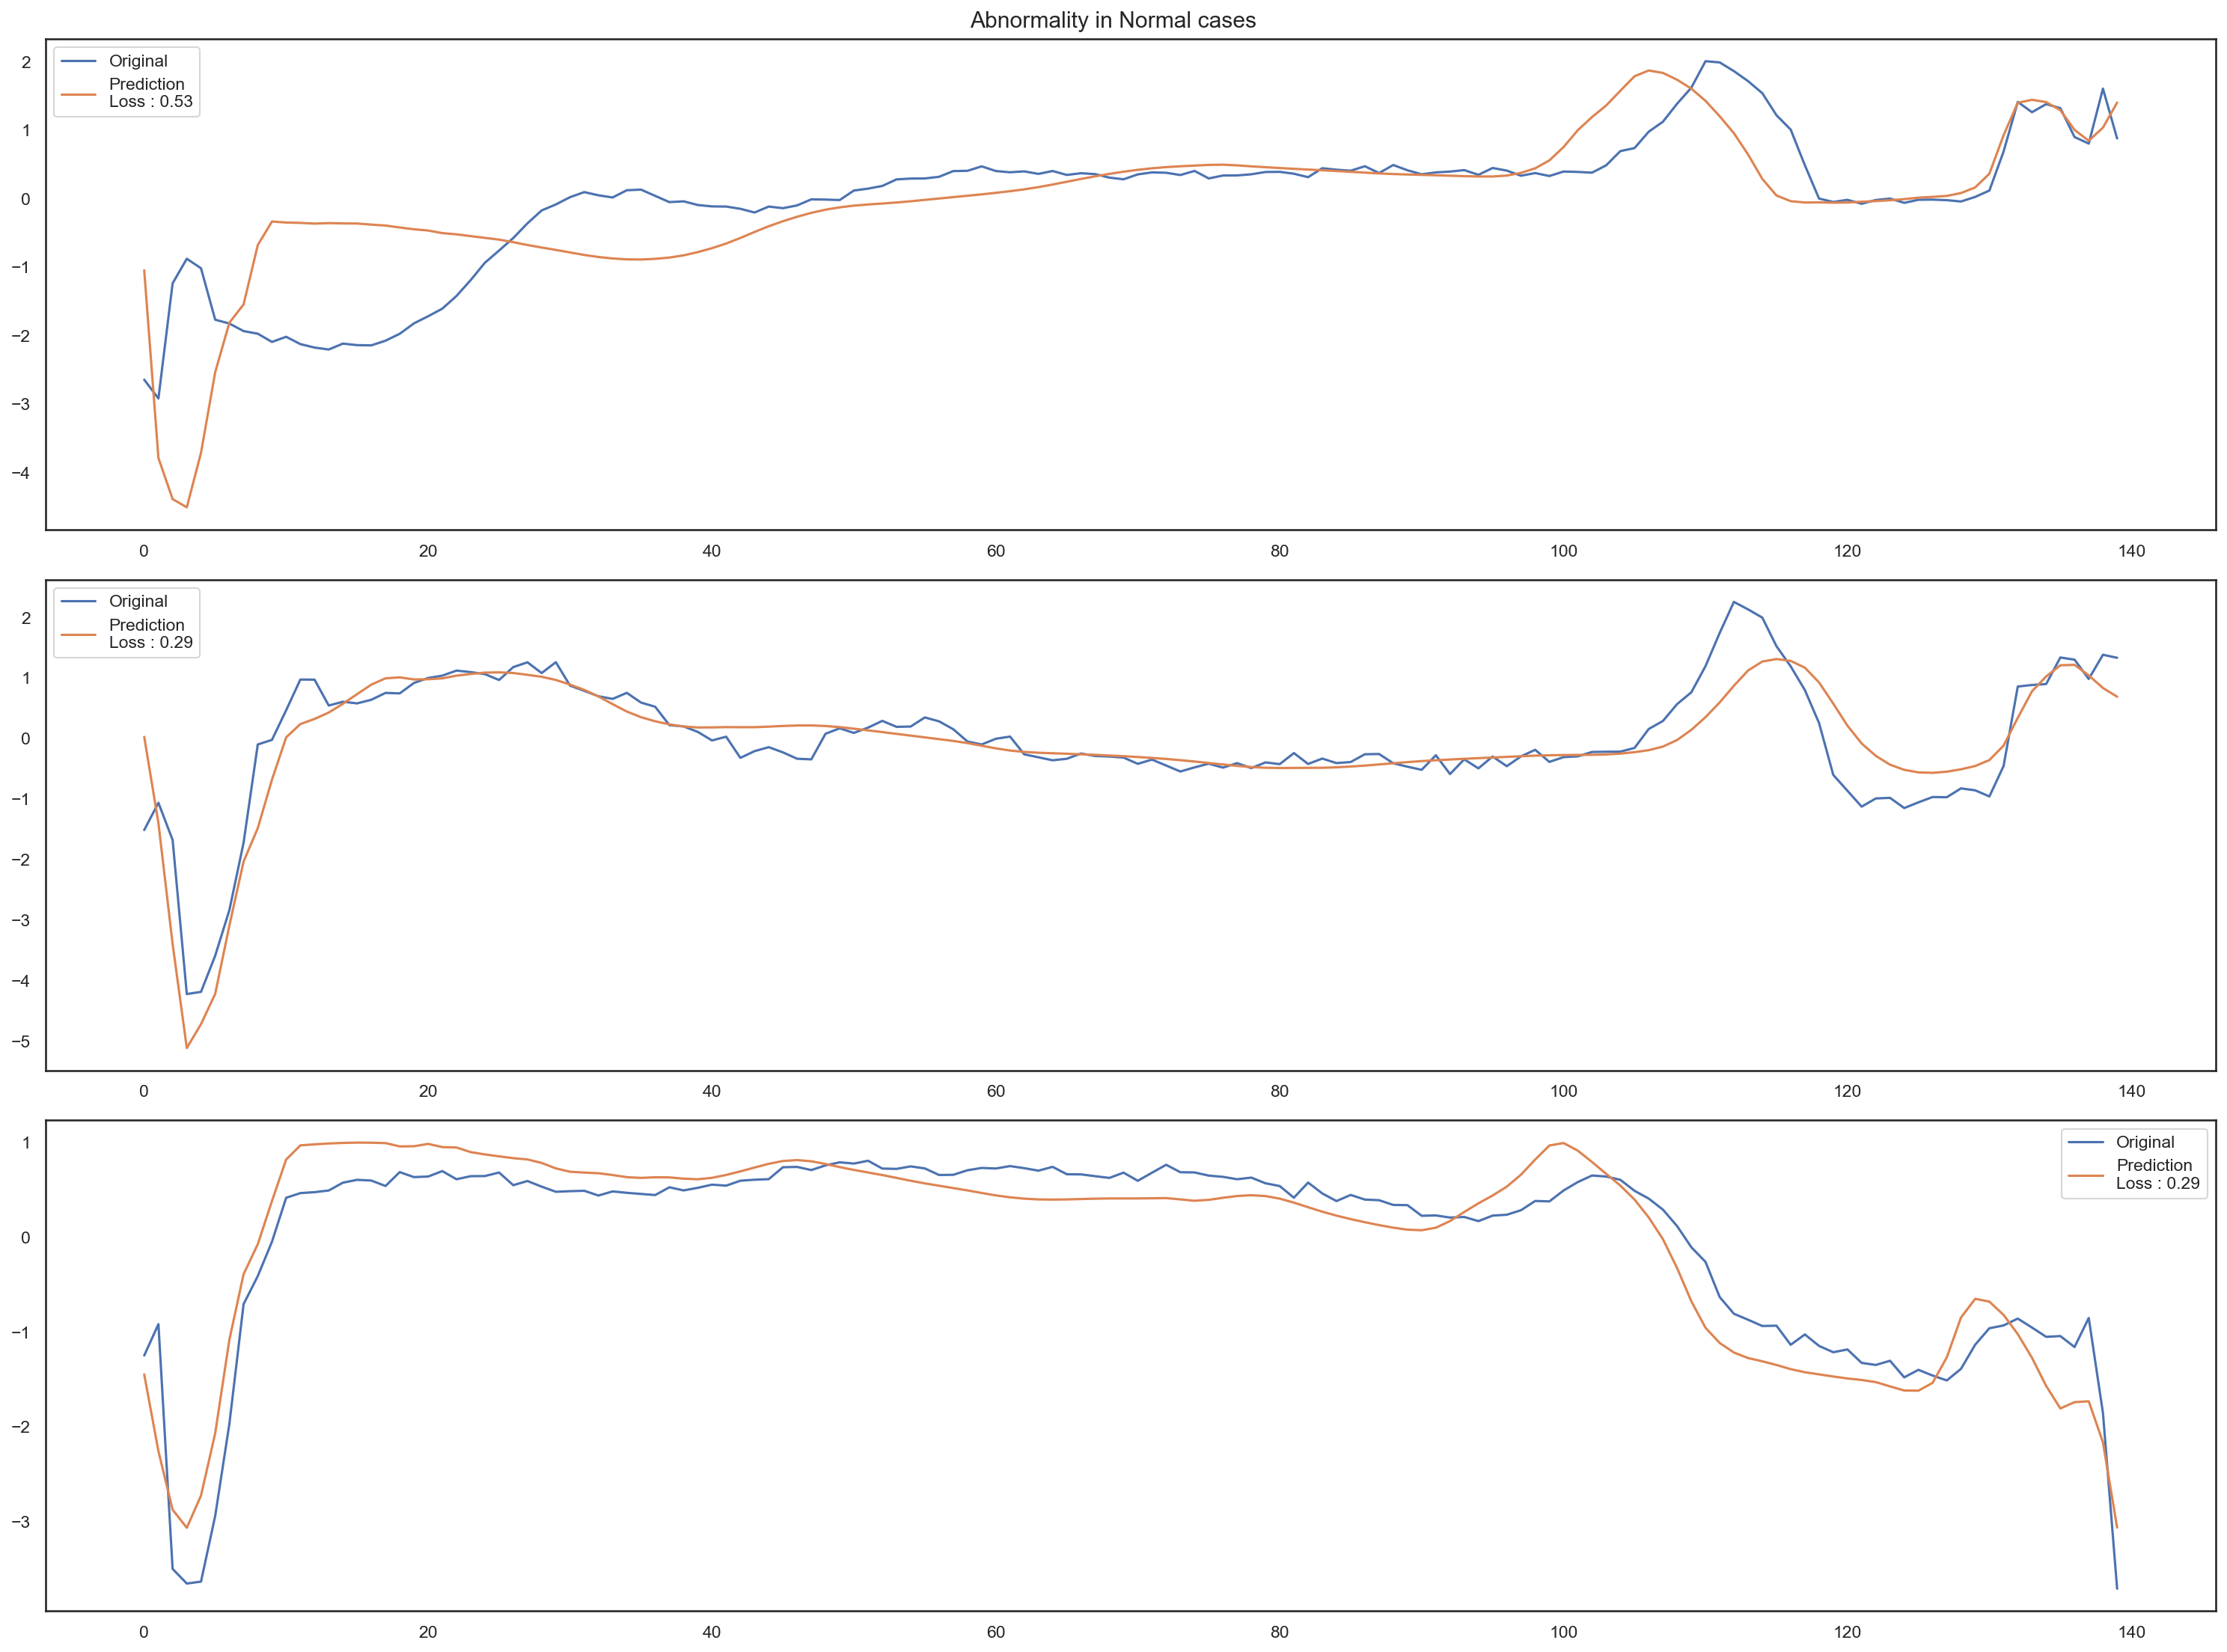

In [56]:
# Create a figure for the subplots
plt.figure(figsize=(20, 15), dpi=150)

# Loop through elements in abnormal_in_normal_lst
for num, element in enumerate(abnormal_in_normal_lst, start=0):
    # Create a subplot
    plt.subplot(len(abnormal_in_normal_lst), 1, num + 1)
    
    # Plot the original time series
    sns.lineplot(x=range(len(element['original'])), y=element['original'], label='Original')
    
    # Plot the predicted time series and display the loss value
    sns.lineplot(x=range(len(element['prediction'])), y=element['prediction'],
                 label=f"Prediction\nLoss : {element['loss']}")
    
# Add a title to the overall figure
plt.suptitle('Abnormality in Normal cases')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot
#plt.savefig('_plots/Abnormality in Normal.jpeg')

# Show the plot
plt.show()

In [57]:
# Initialize a list to store normal instances found in anomaly dataset
normal_in_abnormal_lst = []

# Loop through instances in test_anomaly_dataset
for num, instance in enumerate(test_anomaly_dataset):
    # Set the loaded model to evaluation mode
    loaded_model.eval()

    # Generate predictions and calculate loss using the loaded model
    with torch.inference_mode():
        pred = loaded_model(instance)
        loss = lossfn(pred, instance)
    
    # Check if the loss is below the threshold
    if loss.item() < threshold:
        normal_in_abnormal_lst.append({'original': np.array(instance.squeeze()),
                                       'prediction': np.array(pred.squeeze()),
                                       'loss': round(loss.item(), 2)})

In [58]:
# Calculate the number of instances classified as normal in the anomaly dataset
num_normal_in_abnormal = len(normal_in_abnormal_lst)
num_normal_in_abnormal

14

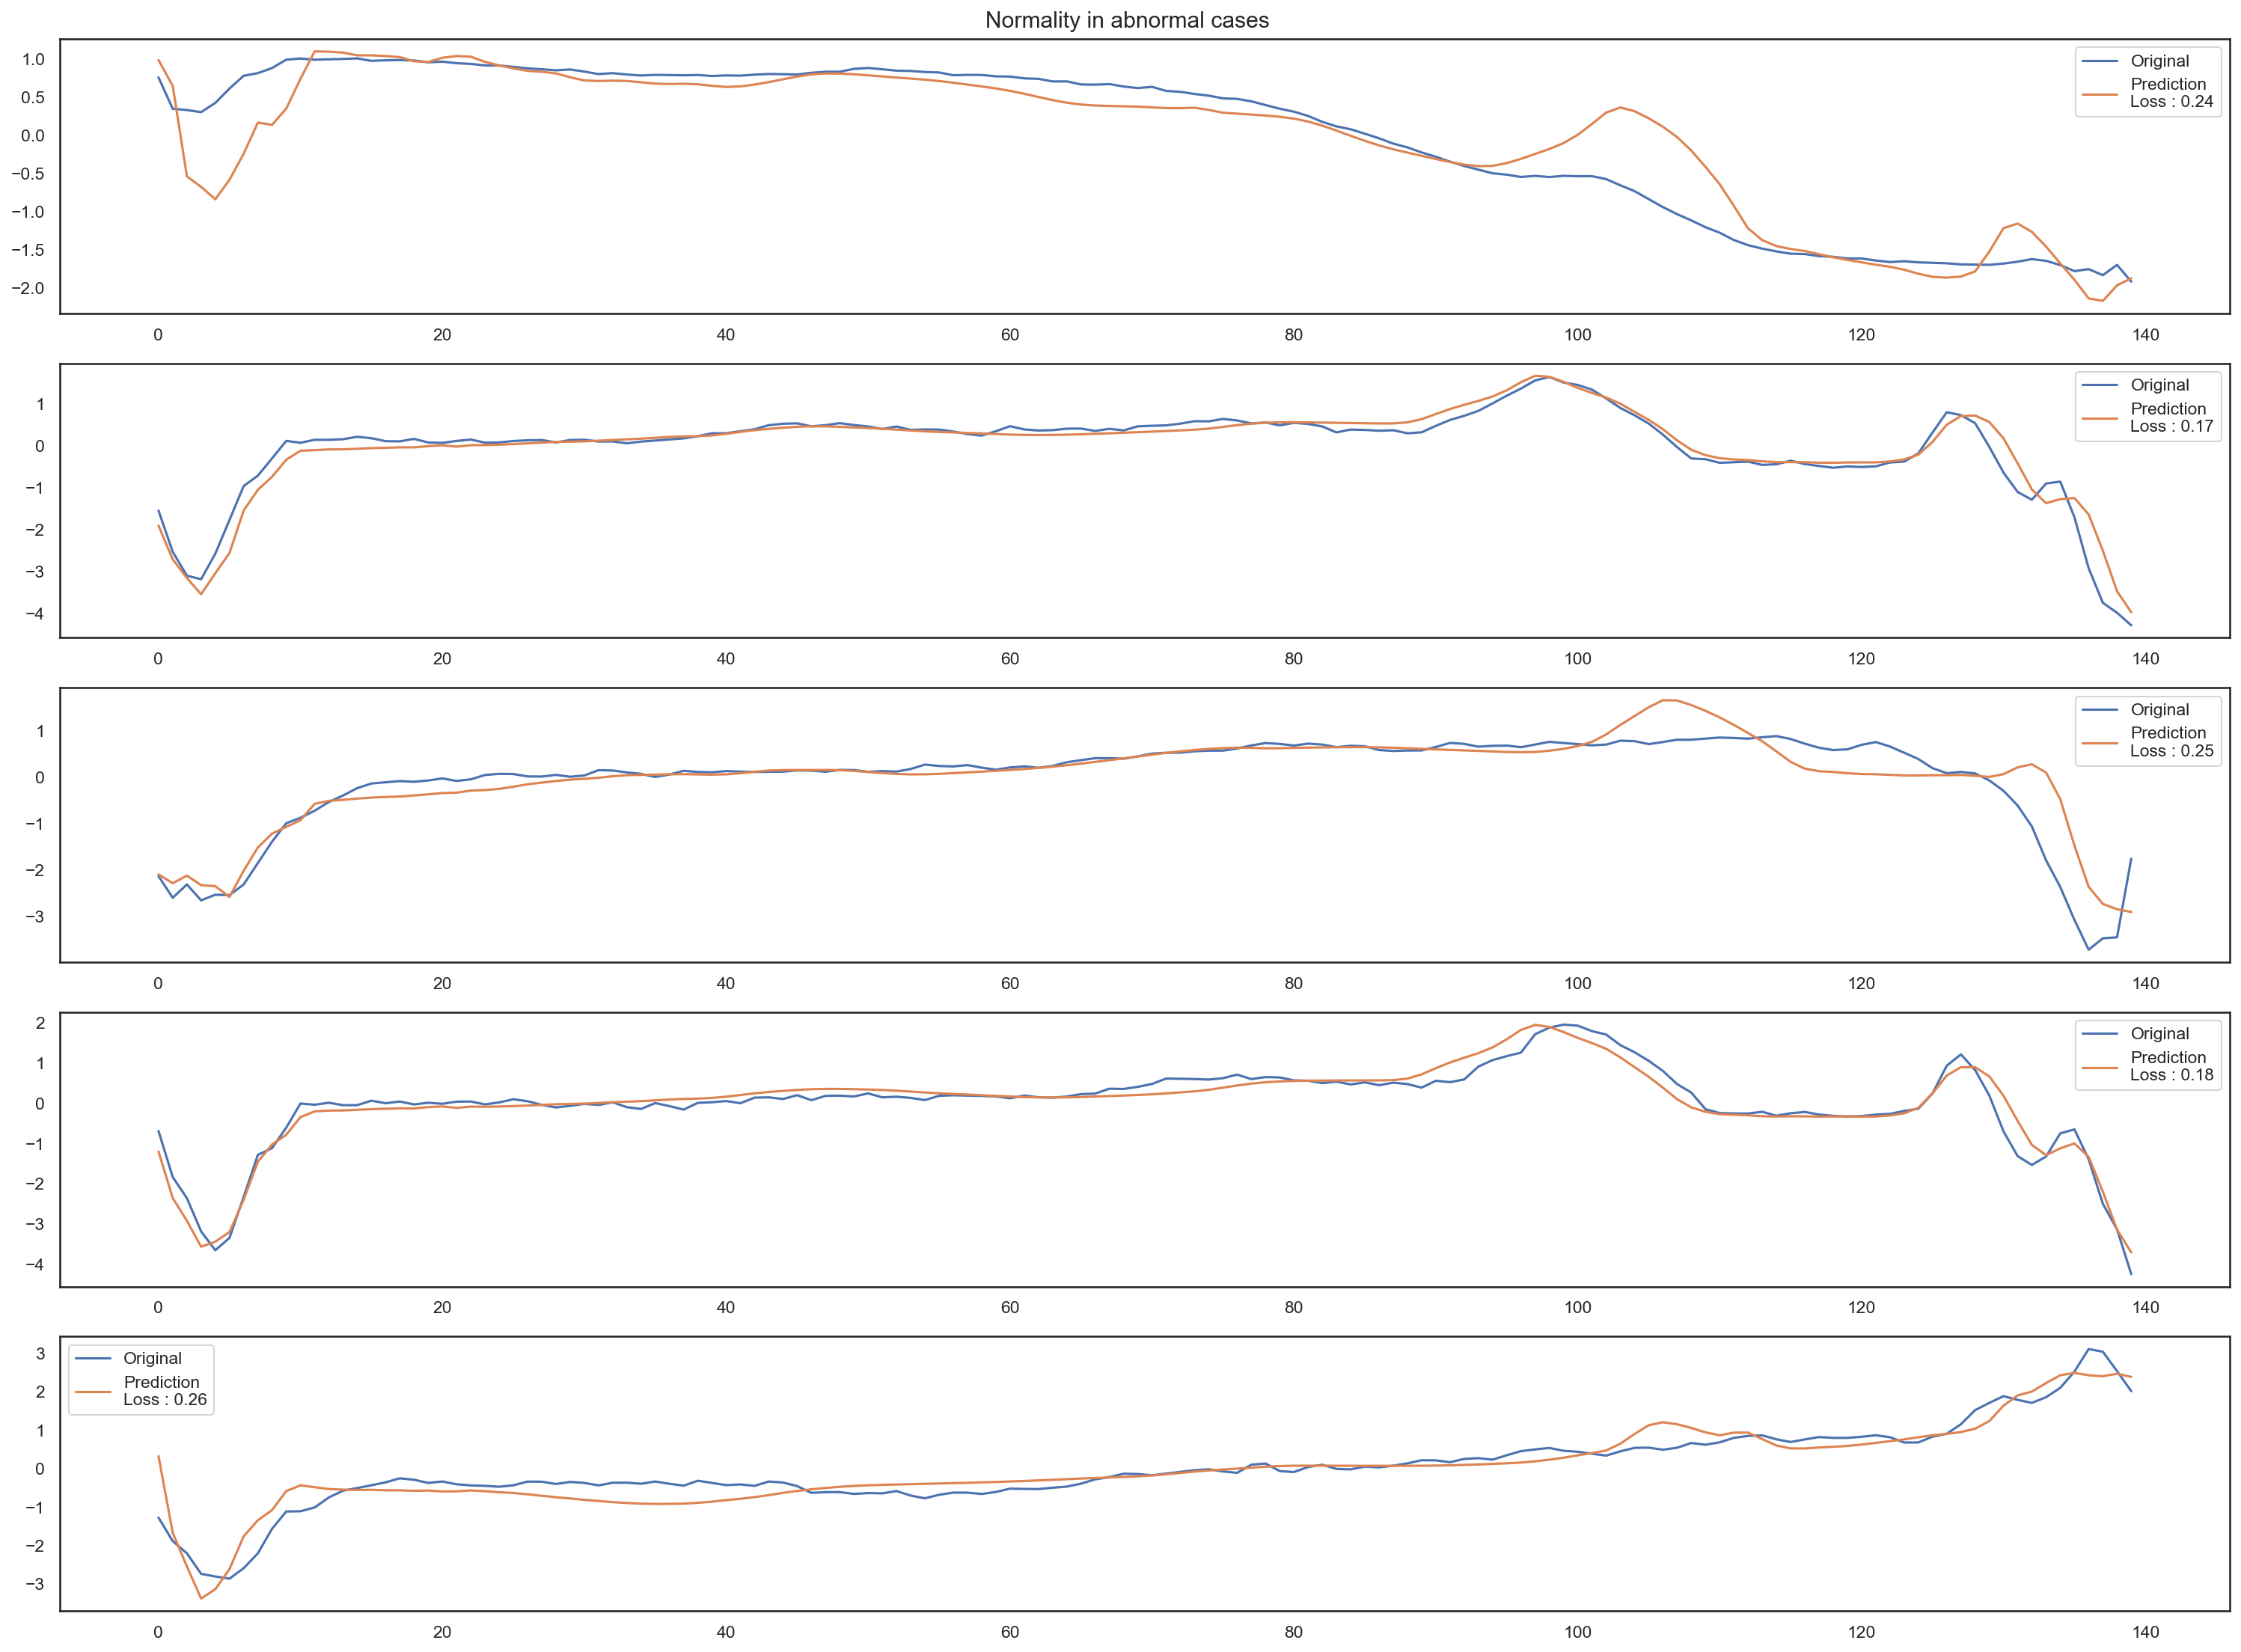

In [59]:
# Create a figure for the subplots
plt.figure(figsize=(20, 15), dpi=150)

# Loop through elements in normal_in_abnormal_lst (limited to the first 5 elements)
for num, element in enumerate(normal_in_abnormal_lst[:5], start=0):
    # Create a subplot
    plt.subplot(len(normal_in_abnormal_lst[:5]), 1, num + 1)
    
    # Plot the original time series
    sns.lineplot(x=range(len(element['original'])), y=element['original'], label='Original')
    
    # Plot the predicted time series and display the loss value
    sns.lineplot(x=range(len(element['prediction'])), y=element['prediction'],
                 label=f"Prediction\nLoss : {element['loss']}")
    
# Add a title to the overall figure
plt.suptitle('Normality in abnormal cases')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot
#plt.savefig('_plots/Normality in abnormal_p1.jpeg')

# Show the plot
plt.show()

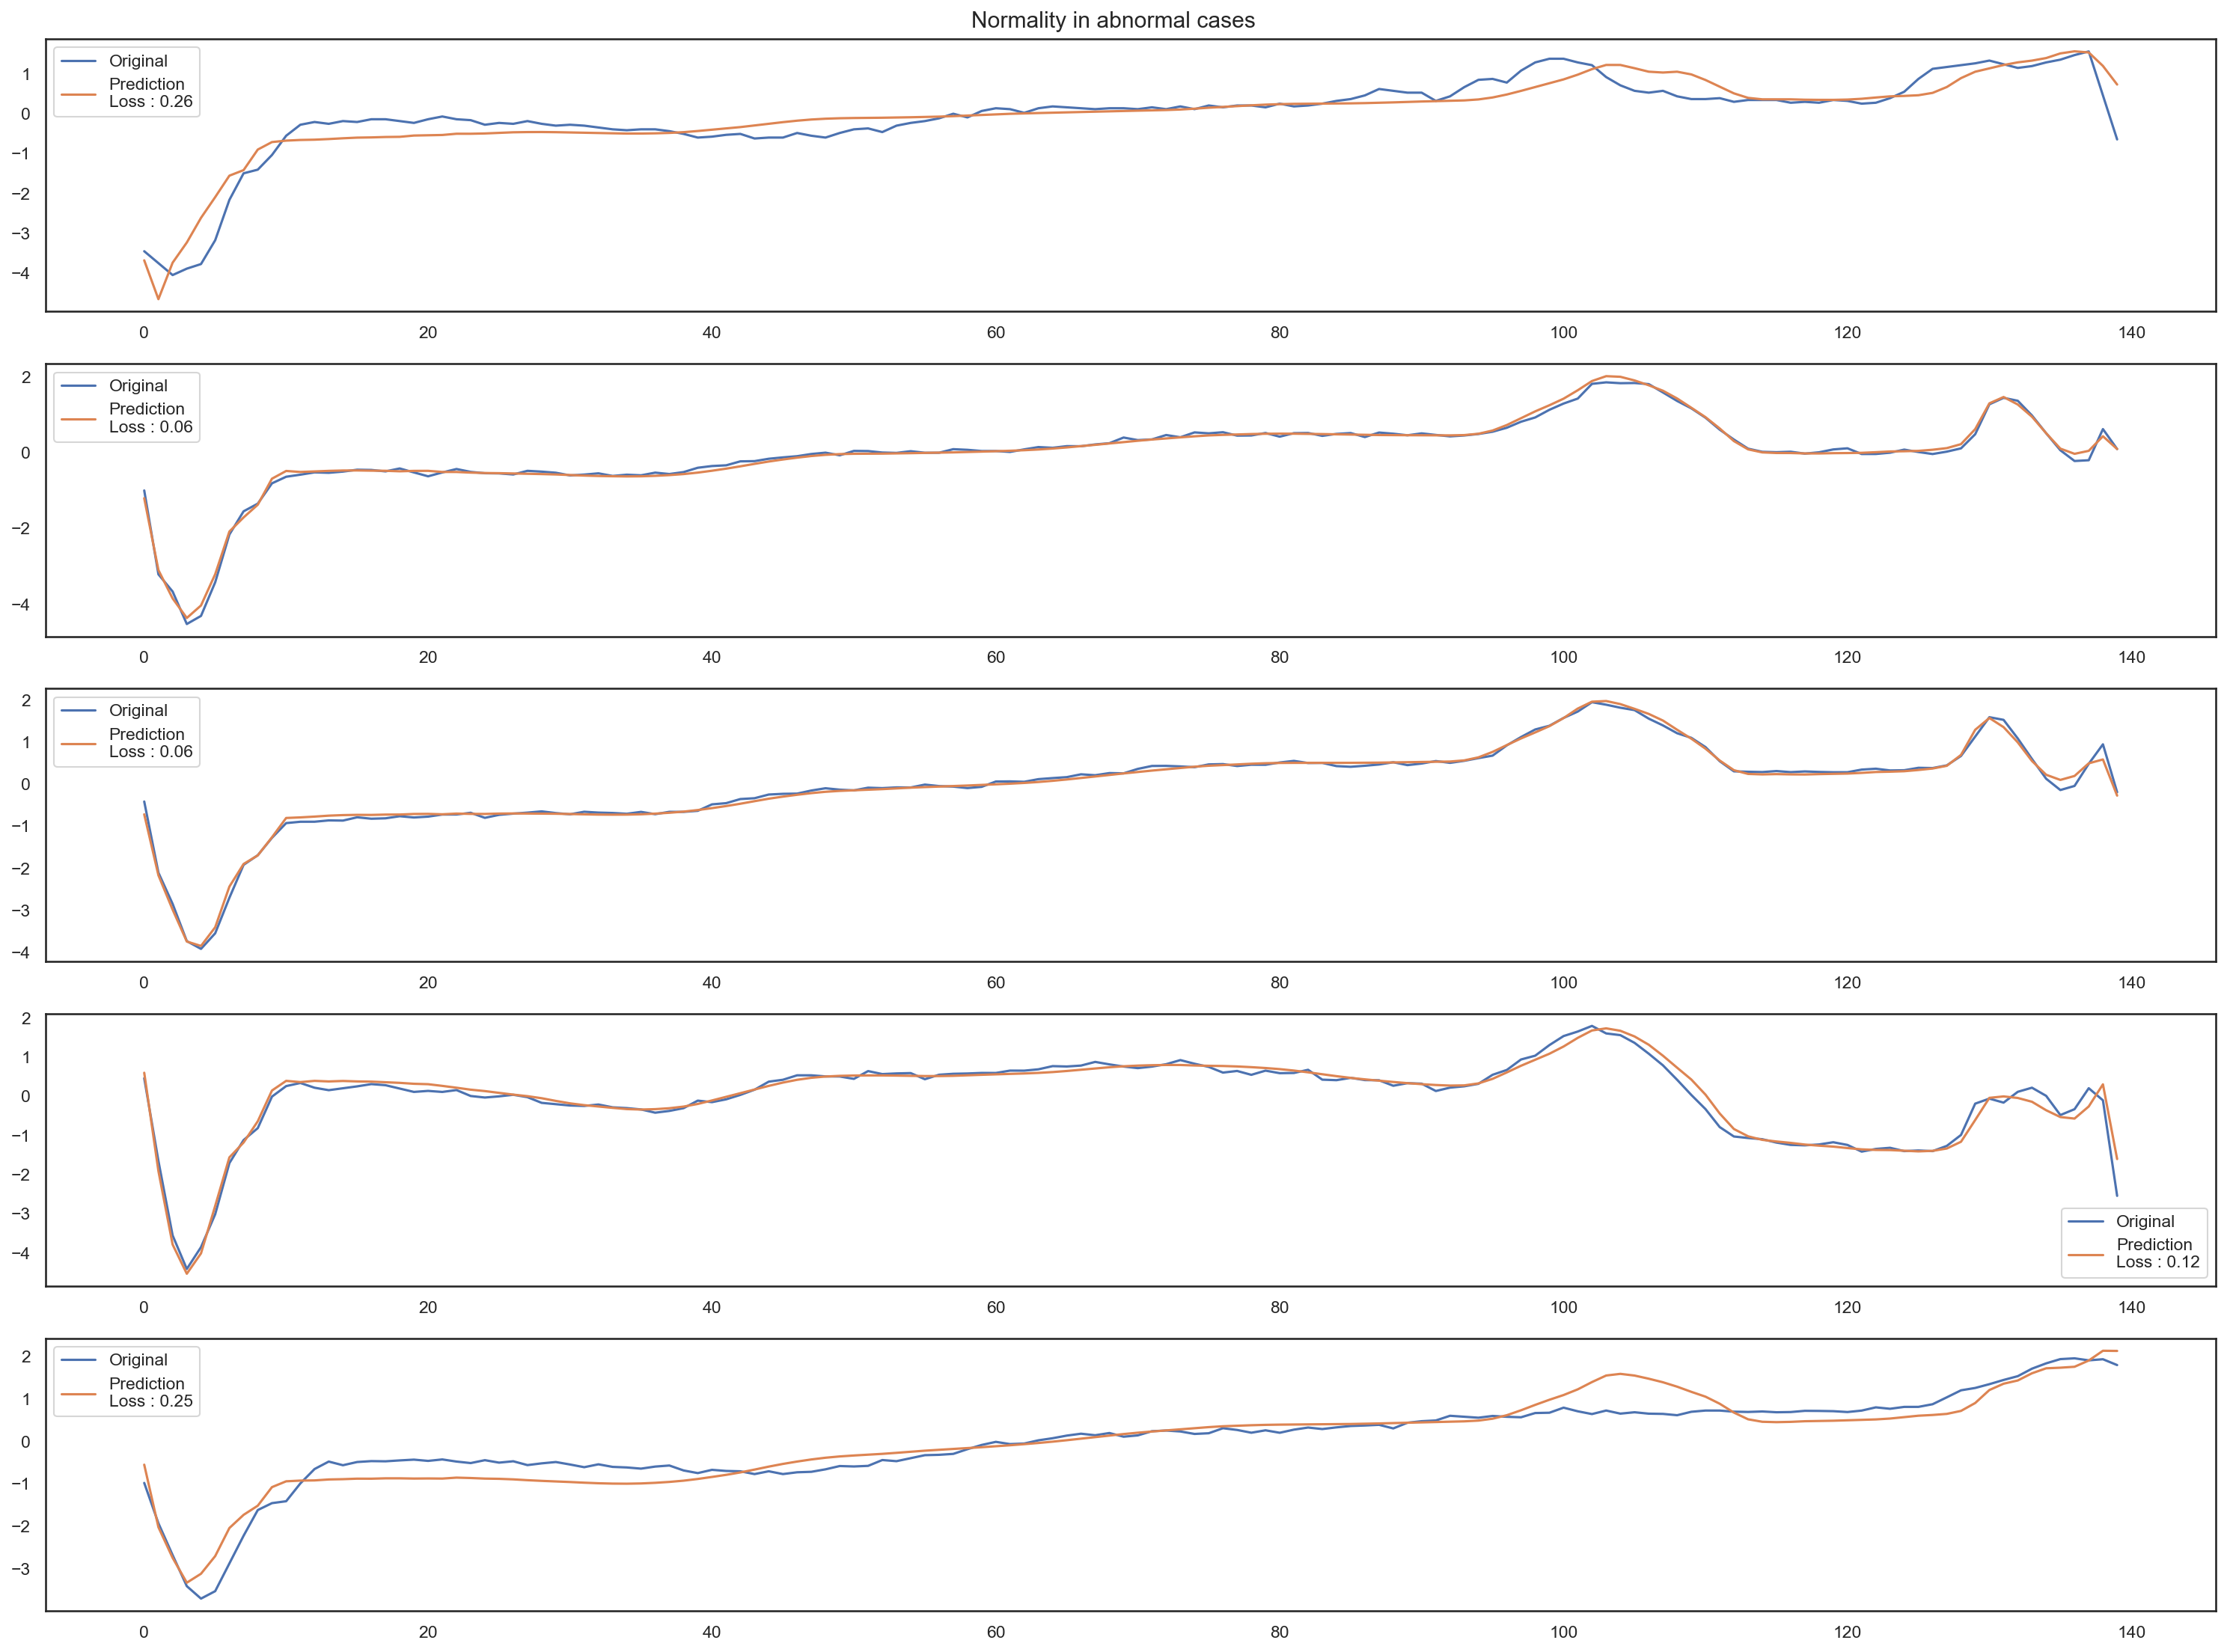

In [60]:
# Create a figure for the subplots
plt.figure(figsize=(20, 15), dpi=150)

# Loop through elements in normal_in_abnormal_lst (from index 5 to 9)
for num, element in enumerate(normal_in_abnormal_lst[5:10], start=0):
    # Create a subplot
    plt.subplot(len(normal_in_abnormal_lst[5:10]), 1, num + 1)
    
    # Plot the original time series
    sns.lineplot(x=range(len(element['original'])), y=element['original'], label='Original')
    
    # Plot the predicted time series and display the loss value
    sns.lineplot(x=range(len(element['prediction'])), y=element['prediction'],
                 label=f"Prediction\nLoss : {element['loss']}")
    
# Add a title to the overall figure
plt.suptitle('Normality in abnormal cases')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot
#plt.savefig('_plots/Normality in abnormal_p2.jpeg')

# Show the plot
plt.show()

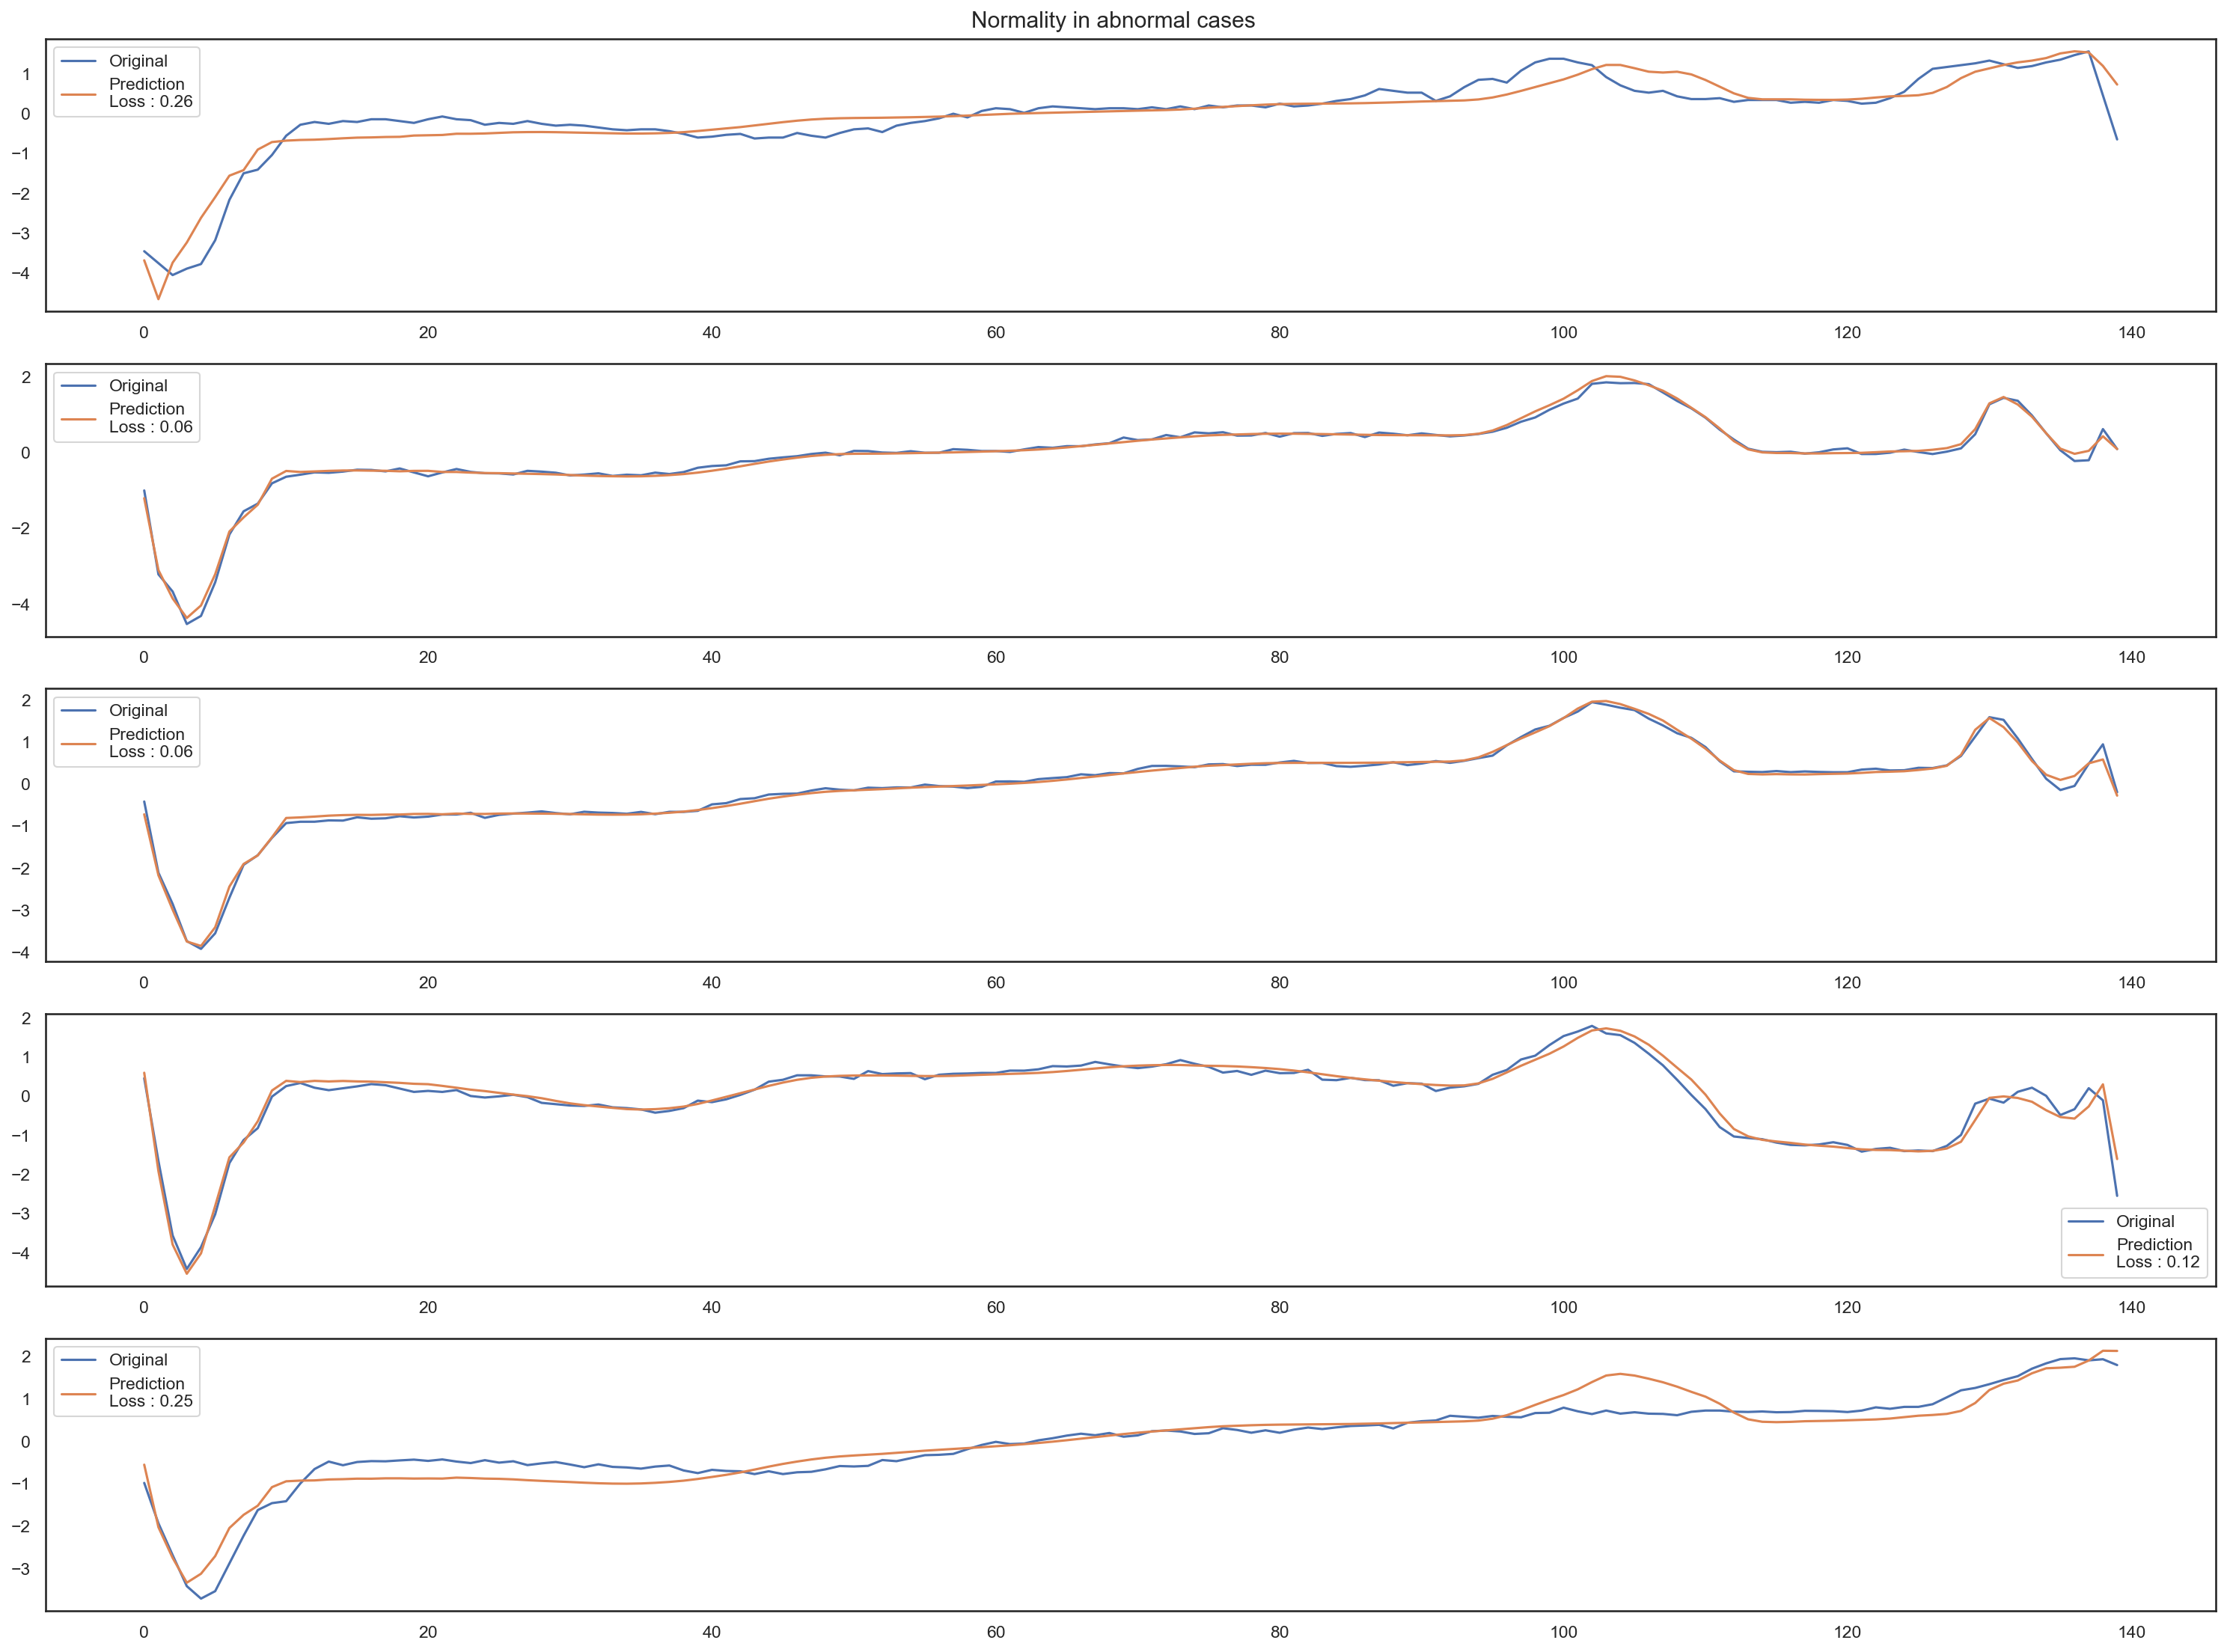

In [61]:
# Create a figure for the subplots
plt.figure(figsize=(20, 15), dpi=150)

# Loop through elements in normal_in_abnormal_lst (from index 5 to 9)
for num, element in enumerate(normal_in_abnormal_lst[5:10], start=0):
    # Create a subplot
    plt.subplot(len(normal_in_abnormal_lst[5:10]), 1, num + 1)
    
    # Plot the original time series
    sns.lineplot(x=range(len(element['original'])), y=element['original'], label='Original')
    
    # Plot the predicted time series and display the loss value
    sns.lineplot(x=range(len(element['prediction'])), y=element['prediction'],
                 label=f"Prediction\nLoss : {element['loss']}")
    
# Add a title to the overall figure
plt.suptitle('Normality in abnormal cases')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot
#plt.savefig('_plots/Normality in abnormal_p1.jpeg')

# Show the plot
plt.show()
